# Exploring Fan Tach Measurement

I would like to read the speed of a computer fan with high accuracy and low
latency.  That seems like a problem that would have been thoroughly analyzed
and solved, but I'm not finding existing solutions.

## Literature

(Dunno.  Add some known filters here.)

## Test Setup

I'm working with a micro controller and a 4-pin fan with PWM input and a tach
output.

The fan is a [Noctua A4x10 5V PWM](https://noctua.at/en/nf-a4x10-5v-pwm).
Noctua have published [a white paper](https://www.noctua.at/pub/media/wysiwyg/Noctua_PWM_specifications_white_paper.pdf) about their PWM system.  They've
also published [a brief description of the fan's
controller IC](https://noctua.at/en/ne_fd1_pwm_ic).

For our purposes, the things to note are that the fan's nominal speed ranges
from 1,000 to 5,000 RPM, it accepts a PWM input at 25 KHz, and it produces a
tach output, which has two pulses per fan resolution.

The micro controller is an ESP32S3.  The 'S3 has typical PWM outputs, and it
has an input capture peripheral.  At 25 KHz, the PWM has 11 bit resolution.
The capture peripheral can timestamp edges of a digital input signal with
the value of a free-running counter that increments at 80 MHz.


In [1]:
# Fan parameters
PWM_FREQ = 25_000
TACH_PULSES_per_REV = 2
FAN_MAX_SPEED = 5000

# MCU parameters
CLK_FREQ = 80_000_000
PWM_BITS = 11
PWM_RESOLUTION = 2**PWM_BITS

#Derived constants
CLK_PERIOD_sec = 1 / CLK_FREQ
CLK_PERIOD_usec = 1_000_000 / CLK_FREQ
PWM_PERIOD_sec = 1 / PWM_FREQ
PWM_PERIOD_usec = 1_000_000 / PWM_FREQ
CLKS_per_PWM = PWM_PERIOD_usec / CLK_PERIOD_usec

print(f'{CLK_PERIOD_usec=} \N{MICRO SIGN}sec')
print(f'{PWM_PERIOD_usec=} \N{MICRO SIGN}sec')

CLK_PERIOD_usec=0.0125 µsec
PWM_PERIOD_usec=40.0 µsec


## Firmware

I've written code for the MCU that runs one of four fixed scenarios and records
every edge of both the output PWM signal and the returning PWM signal.  It
creates a "log file" (actually just a recording of the serial output) that has
a compressed log file.

The log file records a single 32 bit number for each recorded edge.  The
number is one bit identifying the channel, PWM or tach; one bit for direction,
rising or falling; and 30 bits of timestamp.  The timestamp is just the value
of the 80 MHz counter at the instant of the edge.  It wraps around every
13 seconds.

## Read Trace Files

### Imports

In [2]:
%matplotlib ipympl
# %matplotlib notebook
# from ipywidgets import interact

from collections import namedtuple
from enum import IntEnum
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import sys

### Passive Data

In [3]:
class Channel(IntEnum):
    PWM = 1
    TACH = 0

class Dir(IntEnum):
    RISING = 1
    FALLING = 0


class Signal(namedtuple('Signal', 'name, chan, dir, clk')):
    
    def rising_edges(self):
        print(f'{self.dir=}')
        print(f'{self.dir == Dir.RISING=}')
        print(f'{Dir.RISING=}')
        print(f'{1 == Dir.RISING=}')
        print(f'{np.any(self.dir == Dir.RISING)=}')
        return self.clk[self.dir == Dir.RISING]
    
    def falling_edges(self):
        return self.clk[self.dir == Dir.FALLING]

### Scenario

A `Scenario` is a trace run.  It has a description like "Ramps" or "Half speed".
It has two signals, PWM and tach.  And it has an optional file name, if it came
from a file.

In [4]:
class Scenario:

    def __init__(self, file, start_sec = 0):
        self.filename = file
        self._duration = None
        self._read(file, start_clk=int(start_sec * CLK_FREQ))

    @property
    def duration(self):
        if self._duration:
            return self._duration
        return max(np.concatenate([self.pwm.clk[-1:], self.tach.clk[-1:]]))

    @duration.setter
    def duration(self, duration):
        self._duration = duration

    @property
    def title(self):
        return self.description.replace(' scenario', '').title()

    def _read(self, file, start_clk=0):
        contents = open(file).read()
        m = re.search(r'.* scenario', contents)
        assert m, f"can't find scenario description in {file}"
        self.description = m.group(0)
        m = re.search(r'(\d+) events logged', contents)
        assert m, f"can't find event count in {file}"
        self.edge_count = int(m.group(1))

        hex_data = contents[m.span()[1]:]
        hex_edges = re.findall(r'[\da-f]+', hex_data)
        assert len(hex_edges) == self.edge_count
        int_edges = [int(x, base=16) for x in hex_edges]
        self.raw_edges = np.array(int_edges, dtype=np.uint32)

        edges = self._unwrap(self.raw_edges)
        # N.B. edges are now (signed) int64.

        # Yes, really.  We captured some of the edges out of order
        # due to software interrupt latency. 
        edges.sort()    # sorts in place

        chan, dir, clk = self._decode(edges)

        offset = clk[0] - start_clk

        pwm_edges = edges[chan == 1]
        tach_edges = edges[chan == 0]
        self.pwm = Signal('pwm', *self._decode(pwm_edges, offset=offset))
        self.tach = Signal('tach', *self._decode(tach_edges, offset=offset))

    def _unwrap(self, edges):
        """Timestamps wrap around.  Convert to unwrapped."""
        # This function will preserve the flags in the low bits.
        # N.B., sometimes edges are out of order, so the data
        # may wrap backward as well as forward.
        edges = np.array(edges, dtype=np.int64)
        delta = np.diff(edges)
        overflow = delta < -2**31
        underflow = delta > +2**31
        eitherflow = overflow.astype(np.int64) - underflow.astype(np.int64)
        adjustment = 2**32 * eitherflow.cumsum()
        adjustment = np.hstack([[0], adjustment])
        return edges + adjustment

        return edges

    def _decode(self, edges, offset=0):
        # Each edge is 32 bits and encodes
        #  - a channel (tach = 0, PWM = 1)
        #  - a direction (falling = 0, rising = 1)
        #  - a 30 bit timestamp
        chan = edges & 1
        dir = edges >> 1 & 1
        clk = ((edges >> 2) - offset) # & 0x3FFF_FFFF
        return (chan, dir, clk)

    def __repr__(self):
        return f'<{self.__class__.__name__}: {self.description}>'

    def __len__(self):
        return self.edge_count;

#### Unit Test for `_unwrap`

Does that actually work?

In [5]:
# Quick unwrap test
edges = np.array([0xFFFFFFFE, 0, 1, 0xFFFFFFFF,
                  1, 2, 0x7FFFFFFF, 0xFFFF0000, 3], dtype=np.uint32)
unwrapped = Scenario._unwrap(None, edges)
assert list(unwrapped) == [0xFFFFFFFE, 0x100000000, 0x100000001, 0xFFFFFFFF,
                           0x100000001, 0x100000002, 0x17FFFFFFF, 0x1FFFF0000,
                           0x200000003]


## Scenarios

There are five scenarios.

 * **Full Speed** -- The PWM signal is at a steady 100% duty cycle for
   three seconds.

 * **Half Speed** -- The PWM signal is at a steady 50% duty cycle for
   three seconds.

 * **Bang Bang** -- The PWM signal starts at 0.  It jumps to 100%, stays there
 for five seconds, then jumps back to 0 and waits five seconds for the fan
 to stop.

 * **Ramps** -- The PWM signal starts at 0.  It gradually ramps up to 100% over
 five seconds, then it ramps back down to 0 over the next 5 seconds.

 * **Staircase** -- The PWM signal starts at 0.  It increases to 100% in eight
 steps, waiting 1.6 seconds at each step for the fan speed to (almost)
 stabilize.  Then it steps back down to 0 at the same speed.






In [6]:
full_speed_scenario = Scenario('../traces/full-speed.trace')
half_speed_scenario = Scenario('../traces/half-speed.trace')
bang_bang_scenario = Scenario('../traces/bang-bang.trace', 1.0) # Start trace at t=1 sec
ramps_scenario = Scenario('../traces/ramps.trace')
staircase_scenario = Scenario('../traces/staircase.trace', 1.6)
staircase_scenario.duration = 17 * 1.6 * CLK_FREQ

all_scenarios = [
    full_speed_scenario,
    half_speed_scenario,
    bang_bang_scenario,
    ramps_scenario,
    staircase_scenario]

## Data Sanitation

I can test that the recorded traces have some expected properties.  And then I
can fix them up.

### Ordering

Are the trace events in chronological order?

In [7]:
def check_ordering(scenario, verbose=False):
    if verbose:
        print(f'Checking edge order in {scenario.description}')
    for sig in [scenario.pwm, scenario.tach]:
        delta = np.diff(sig.clk)
        neg_indices = (delta < 0).nonzero()[0]
        if len(neg_indices):
            print(f'{sig.name}: {len(neg_indices)} out of order sample(s)')
            print(f'{sig.name}: {neg_indices=}')
            print(f'{sig.name}: {min(delta[neg_indices])=}')

for scenario in all_scenarios:
    check_ordering(scenario)

### Fix Edge Directions

For reasons I don't want to explore, a small number of rising edges in the tach
signal are recorded as falling.  They happen one at a time,
...R F R F **>F<** F R F...  They happen at the right time, about the same
interval as surrounding edges.

So we look for those and fix their polarity.

In [8]:
def fixup_tach_dir(scenario, verbose=False):
    if verbose:
        print(f'Fixing up tach directions in {scenario.description}')
    tach = scenario.tach
    dir = tach.dir
    even = dir[::2]
    odd = dir[1::2]
    if even.sum() > odd.sum():
        # rising edge first
        ones = even
        zeroes = odd
        offset = 2
        prefix = [1, 0]
    else:
        # falling edge first
        ones = odd
        zeroes = even
        offset = 1
        prefix = [1]
    assert (zeroes == 0).all()
    if (ones == 1).all():
        # no fixup needed
        return

    anomalies = (ones == 0).nonzero()[0]
    assert anomalies.size < 0.01 * dir.size, "too many anomalous events"
    anom_indices = 2 * anomalies + offset
    p_dir = np.hstack([prefix, dir])
    p_anom_indices = anom_indices + offset

    def check_sequence(ix):
        neighbors = np.arange(5) + ix - 1
        n_dir = list(p_dir[neighbors])
        return n_dir == [1, 0, 0, 0, 1]

    def check_timing(ix):
        if ix == 0 or ix == len(tach.clk) - 1:
            return True
        delta0 = tach.clk[ix] - tach.clk[ix - 1]
        delta1 = tach.clk[ix + 1] - tach.clk[ix]
        change = abs((delta0 - delta1) / (delta0 + delta1))
        return change < 0.01

    for ix in anom_indices:
        assert check_sequence(ix), "unexpected direction sequence"
        assert check_timing(ix), "abrupt timing change"
    # All good, modify the signal
    for ix in anom_indices:
        tach.dir[ix] = 1

for scenario in all_scenarios:
    fixup_tach_dir(scenario)


### Alternating Edges

Now that the tach signal is fixed every signal should strictly alternate
rising and falling edges.


In [9]:
def verify_alternating_edges(scenario, verbose=False):
    if verbose:
        print(f'Verifying {scenario.description}')
    for sig in [scenario.pwm, scenario.tach]:
        dir = sig.dir
        if len(dir):
            try:
                assert np.all(dir[::2] == dir[0])
                assert np.all(dir[1::2] != dir[0])
            except AssertionError:
                d0 = int(dir[0])
                anomalies = (dir != (d0 + np.arange(len(dir))) % 2).nonzero()[0]
                print(f'{sig.name}: {len(anomalies)=}')
                print(f'{sig.dir.shape=}')
                print(f'{sig.dir.sum()=}')
                print(f'{anomalies=}')
                print(f'{sig.clk=}')
                for i in anomalies[:3]:
                    neighbors = np.arange(max(0, i - 4), i + 5)
                    n_clk = sig.clk[neighbors]
                    n_delta = np.diff(n_clk)
                    print(f'{scenario.description}: {sig.name}')
                    print(f'    at {i}')
                    print(f'    dir {dir[neighbors]}')
                    print(f'    clk {n_clk}')
                    print(f'    clk \u0394 {n_delta}')
                delta = np.diff(sig.clk)
                print(f'{sig.name}: {np.histogram(delta)=}')

for scenario in all_scenarios:
    verify_alternating_edges(scenario)

### Check PWM Spacing

The PWM signal should either be quiet for long periods (0% or 100%) or its
rising edges should be closely synced to `PWM_FREQ`.

This isn't perfect.  And being a few namoseconds off isn't a big deal.  So just
print the anomalies.

In [10]:

def check_pwm_spacing(scenario, verbose=False):
    if verbose:
        print(f'Checking PWM timing in {scenario.description}')
    pwm = scenario.pwm
    rising_clks = pwm.clk[pwm.dir == 0]
    intervals = np.diff(rising_clks)
    idict = {}
    while intervals.size:
        k = int(intervals[0])
        idict[k] = intervals[intervals == k].size
        intervals = intervals[intervals != k]
    expected = CLKS_per_PWM
    anom = {k: idict[k] for k in idict if k != expected and k < 1_000_000}
    if anom:
        print(f'{scenario.description}: unstable PWM timing', file=sys.stderr)
        for k in anom:
            nsamp = idict[k]
            usec = k * CLK_PERIOD_usec
            print(f'   {nsamp} samples at {usec:.6} usec', file=sys.stderr)

for scenario in all_scenarios:
    check_pwm_spacing(scenario)

Ramps scenario: unstable PWM timing
   895 samples at 40.0125 usec
   1151 samples at 40.025 usec
   1 samples at 80.0 usec
   1151 samples at 39.975 usec
   895 samples at 39.9875 usec
Staircase scenario: unstable PWM timing
   6 samples at 45.0 usec
   6 samples at 35.0 usec


## Graph the PWM Signal

Let's rewrite the PWM from a sequence of edges to a sequence of (X, Y) points
for plotting.  Since the PWM is well behaved, the points should be much smaller.


In [12]:
# def iarray(*args, **kwargs):
#     return np.array(*args, dtype=np.int64, **kwargs)

class HorizVert:

    """record a set of points to draw horizontal and vertical lines"""

    def __init__(self, max_points, debug=False):
        self.x = 0
        self.y = None
        self._points = np.empty(shape=(max_points, 2), dtype=np.int64)
        self.index = 0
        self.debug = debug

    def set_X(self, x, label='_'):
        if self.debug:
            print(f'{label}: X {self.x} -> {x}')
        assert x > self.x
        assert self.y is not None
        self._points[self.index] = [x, self.y]
        self.index += 1
        self.x = x

    def set_Y(self, y, label='_'):
        if self.debug:
            print(f'{label}: Y {self.y} -> {y}')
        assert 0 <= y <= CLKS_per_PWM
        self._points[self.index] = [self.x, y]
        self.index += 1
        self.y = y

    @property
    def points(self):
        return np.array(self._points[:self.index])


def make_points(signal, max_time=None, debug=False):

    def dbg_prt(*a, **kw):
        if (debug):
            print(*a, **kw)
            sys.stdout.flush()

    P = CLKS_per_PWM
    dir = signal.dir
    clk = signal.clk
    hv = HorizVert(3 * clk.size + 2, debug=debug)
    if clk.size == 0:
        # No edges.  Assume 100% PWM.
        hv.set_Y(P, 'A')
        hv.set_X(max_time, 'A')
        return hv.points
    if max_time is None:
        max_time = clk[-1]

    if dir[0] == Dir.FALLING:
        dir = np.insert(dir, 0, [Dir.RISING])
        clk = np.insert(clk, 0, [0])

    if dir[-1] == Dir.RISING:
        if clk[-1] < max_time - P:
            dir = np.append(dir, [Dir.FALLING])
            clk = np.append(clk, [max_time])
    dbg_prt(f'adjusted: {clk}')

    assert clk.size % 2 == 0
    prev_up = 0
    prev_wid = None
    for (up, dn) in np.split(clk, clk.size // 2):
        wid = dn - up
        dbg_prt(f'up={up} dn={dn} wid={wid} '
                f'prev_up={prev_up} prev_wid={prev_wid}')
        assert wid > 0

        if up - prev_up > 1.5 * P:
            # multi-cycle zero
            if prev_wid is not None:
                hv.set_X(prev_up + P, 'B')
            hv.set_Y(0, 'B')
            # hv.set_X(up, 'B')
            prev_wid = 0
            prev_up = up

        if wid > P:
            # multi-cycle pulse
            f_wid = wid % P
            i_wid = wid - f_wid
            if prev_wid is not None:
                hv.set_X(up, 'C')
            hv.set_Y(P, 'C')
            # hv.set_X(up + i_wid, 'C')
            # hv.set_Y(f_wid, 'C')
            up += i_wid
            wid = f_wid
            prev_wid = P

        #  if prev_wid is None:
        #     hv.set_Y(wid, 'D')
        if wid != prev_wid:
            if prev_wid is not None:
                hv.set_X(up, 'E')
            hv.set_Y(wid, 'E')
            prev_wid = wid
            
        prev_up = up
        # prev_wid = wid % P

    dbg_prt(f'END: max_time={max_time} prev_up={prev_up} prev_wid={prev_wid}')
    if max_time > prev_up + P:
        hv.set_X(prev_up + P, 'F')
        hv.set_Y(0, 'F')
        prev_up += P
    if max_time > prev_up:
        hv.set_X(max_time, 'F')

    return hv.points

Does that work?  Let's try a unit test.

In [13]:
#     |  |  |  |
# tv1 -__--_--_-__
# tv2 ----__-_____
 
p = int(CLKS_per_PWM)
tv1_dir = np.array([1, 0, 1, 0, 1, 0, 1, 0])
tv1_clk = np.array([0, 1000, p, p + 2000, 2*p, 2*p + 2000, 3*p, 3*p + 1000])
tv2_dir = np.array([0, 1, 0])
tv2_clk = np.array([p + 1000, 2*p, 2*p+1000])
tv1_signal = Signal(name='tv1', clk=tv1_clk, dir=tv1_dir, chan=None)
tv2_signal = Signal(name='tv2', clk=tv2_clk, dir=tv2_dir, chan=None)

tv1_points = make_points(tv1_signal, 4*p, debug=False)
# print(f'{tv1_points=}')
tv1_points_expected = np.array(
      [[    0,  1000],
       [ 3200,  1000],
       [ 3200,  2000],
       [ 9600,  2000],
       [ 9600,  1000],
       [12800,  1000]])
assert (tv1_points == tv1_points_expected).all()

tv2_points = make_points(tv2_signal, 4*p, debug=False)
# print(f'{tv2_points=}')
tv2_points_expected = np.array(
      [[    0,  3200],
       [ 3200,  3200],
       [ 3200,  1000],
       [ 9600,  1000],
       [ 9600,     0],
       [12800,     0]])
assert (tv2_points == tv2_points_expected).all()

Plot the test vectors.

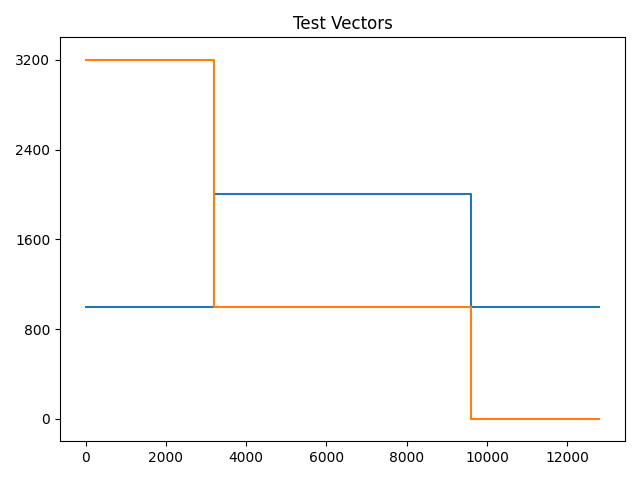

In [14]:
def plot_pwm_alone(title, *pwm_series):
    fig, axes = plt.subplots()
    axes.set_title(title)
    if issubclass(pwm_series[0].dtype.type, np.floating):
        axes.set_ylim([-0.05, +1.05])
    else:
        axes.set_ylim([-200, CLKS_per_PWM + 200])
        axes.set_yticks(np.arange(0, CLKS_per_PWM + 1, CLKS_per_PWM / 4))
    for curve in pwm_series:
        x = curve[:,0]
        y = curve[:,1]
        # if real_units:
        #     x = x * CLK_PERIOD_sec
        #     y = y / CLKS_per_PWM
        axes.plot(x, y)
    fig.tight_layout()
    plt.show()

plot_pwm_alone('Test Vectors', tv1_points, tv2_points)

# x1 = tv1_points[:,0]
# y1 = tv1_points[:,1]
# x2 = tv2_points[:,0]
# y2 = tv2_points[:,1]
# if False:
#     x1 *= CLK_PERIOD_sec
#     y1 /= CLKS_per_PWM
#     x2 *= CLK_PERIOD_sec
#     y2 /= CLKS_per_PWM
# fig, axes = plt.subplots()
# axes.set_ylim([-100, CLKS_per_PWM + 100])
# axes.plot(x1, y1)
# axes.plot(x2, y2)
# plt.show()

At this point (ahem), the horizontal axis is time, in capture clock ticks
since the beginning of the trace, and the vertical axis is pulse width,
also in ticks.

So let's convert that to real units: horizontal scale in seconds, vertical
scale in $[0..1]$.

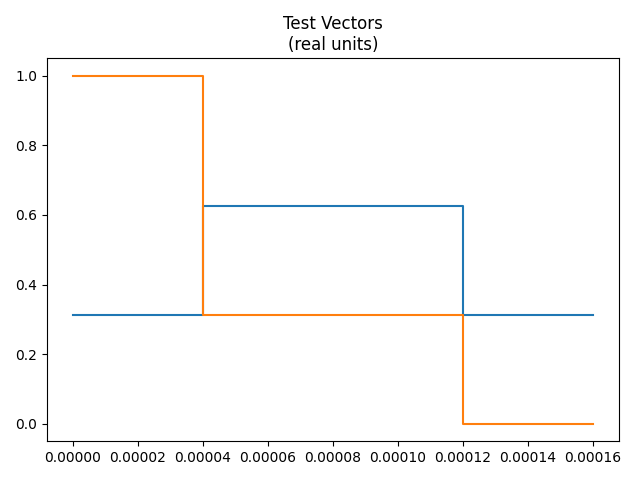

In [15]:
def pwm_to_real_units(pwm_points):
    real_pts = pwm_points.astype(np.float64)
    real_pts[:,0] *= CLK_PERIOD_sec
    real_pts[:,1] /= CLKS_per_PWM
    return real_pts


real_tv1 = pwm_to_real_units(tv1_points)
real_tv2 = pwm_to_real_units(tv2_points)
plot_pwm_alone('Test Vectors\n(real units)', real_tv1, real_tv2)


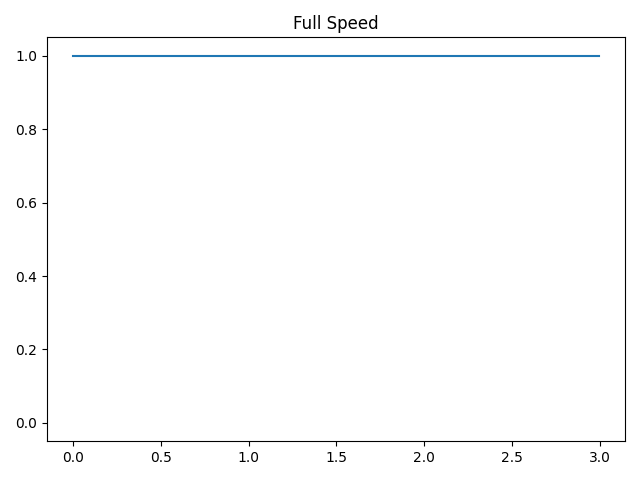

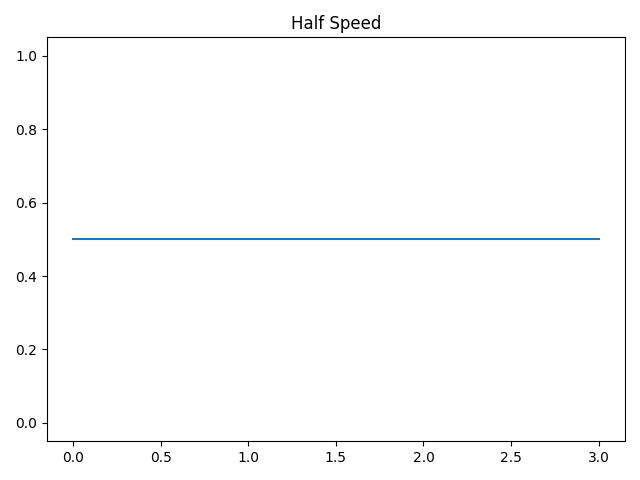

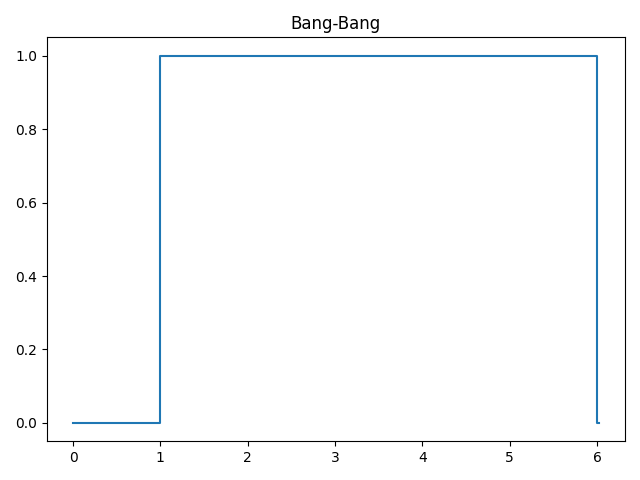

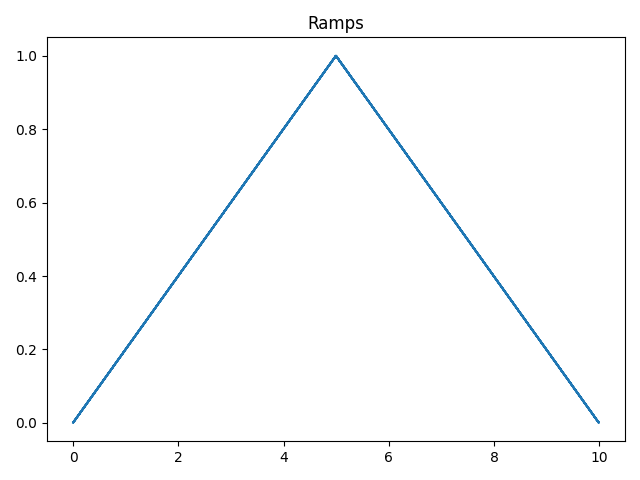

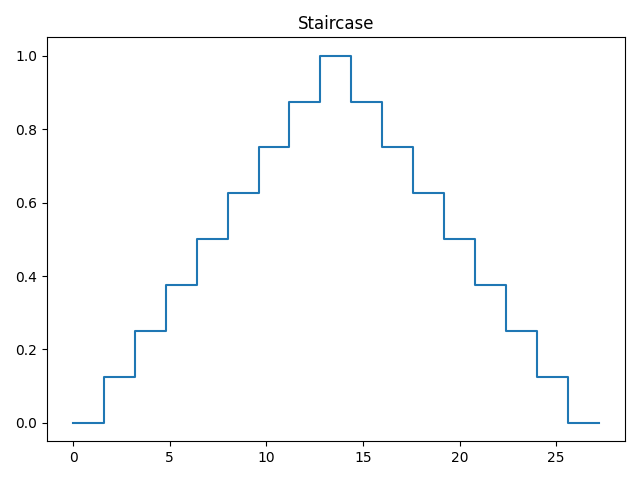

In [16]:
def real_pwm_points(scenario):
    raw_pts = make_points(scenario.pwm, scenario.duration)
    real_pts = pwm_to_real_units(raw_pts)
    return real_pts

for scenario in all_scenarios:
    scenario.pwm_points = real_pwm_points(scenario)

def scenario_plot_pwm_alone(scenario):
    plot_pwm_alone(scenario.title, scenario.pwm_points)

for scenario in all_scenarios:
    scenario_plot_pwm_alone(scenario)

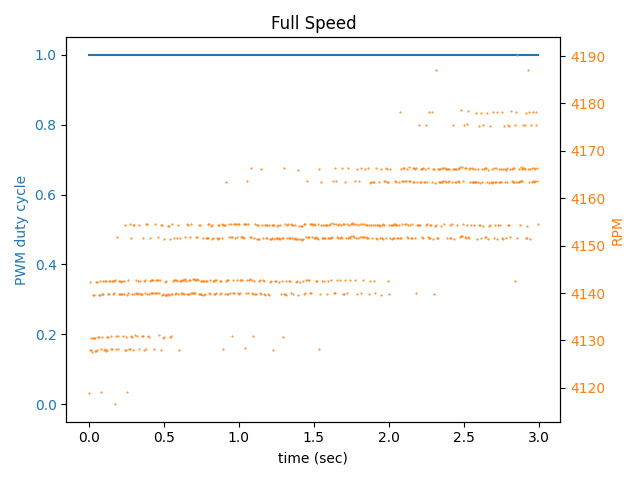

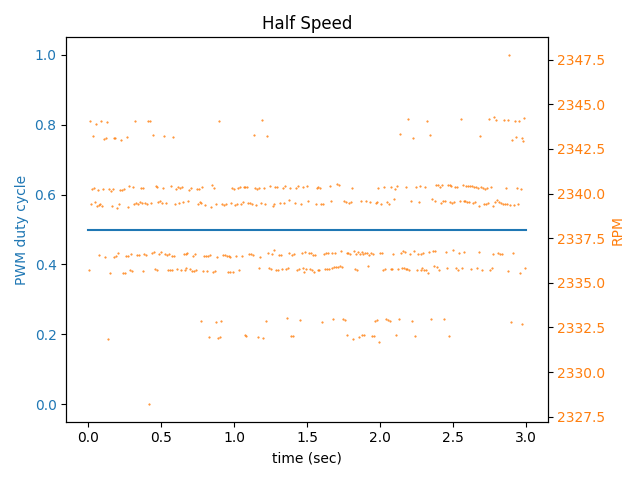

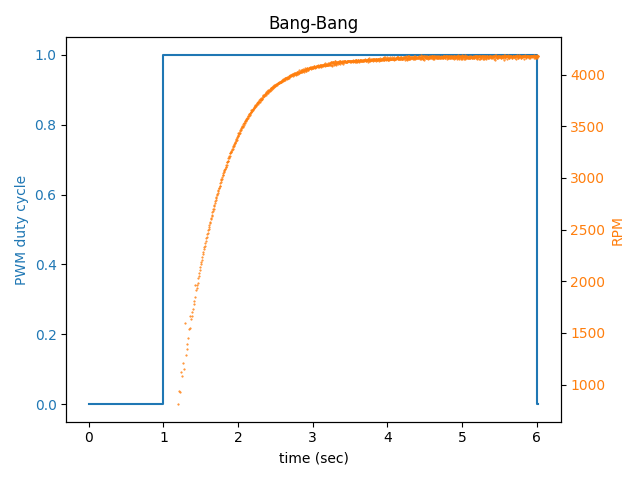

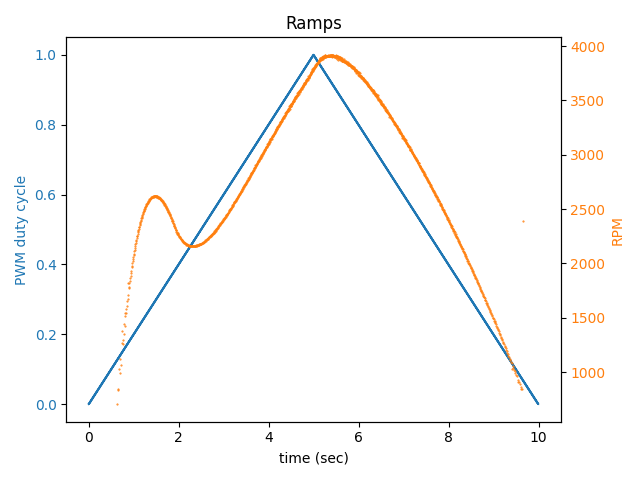

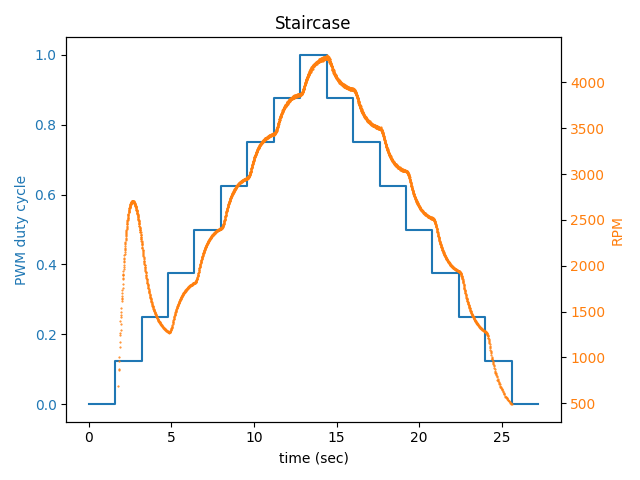

In [17]:
# print(f'{plt.rcParams["axes.prop_cycle"]=}')

def raw_tach_points(scenario):
    clk = scenario.tach.clk
    x = clk[1:] * CLK_PERIOD_sec
    y = CLK_FREQ / np.diff(clk) * 60 / 2 / TACH_PULSES_per_REV
    return np.vstack([x, y]).T

def plot_pwm_tach(title, pwm_pts, tach_pts, fname=None):
    fig, axes = plt.subplots()
    axes.set_title(title)
    axes.set_ylim([-0.05, +1.05])
    pwm_curve, = axes.plot(pwm_pts[:,0], pwm_pts[:,1])
    axes.set_xlabel('time (sec)')
    axes.set_ylabel('PWM duty cycle', color=pwm_curve.get_color())
    axes.tick_params(axis='y', labelcolor=pwm_curve.get_color())

    ax2 = axes.twinx()
    ax2.plot([], []) # skip the first color
    tach_points, = ax2.plot(tach_pts[:,0], tach_pts[:,1], '.', markersize=1)
    tach_points.set_markerfacecolor(tach_points.get_color())
    ax2.tick_params(axis='y', labelcolor=tach_points.get_color())
    ax2.set_ylabel('RPM', color=tach_points.get_color())
    # ax2.set_ylim([-200, +4400])

    fig.tight_layout()
    if fname:
        fig.savefig(fname, dpi=600)
    plt.show()


def scenario_plot_pwm_tach(scenario):
    tach_pts = raw_tach_points(scenario)
    fname = scenario.filename
    fname = os.path.splitext(fname)[0]
    fname = os.path.basename(fname)
    fname += '.png'
    plot_pwm_tach(scenario.title, scenario.pwm_points, tach_pts, fname=fname)

for scenario in all_scenarios:
    scenario_plot_pwm_tach(scenario)

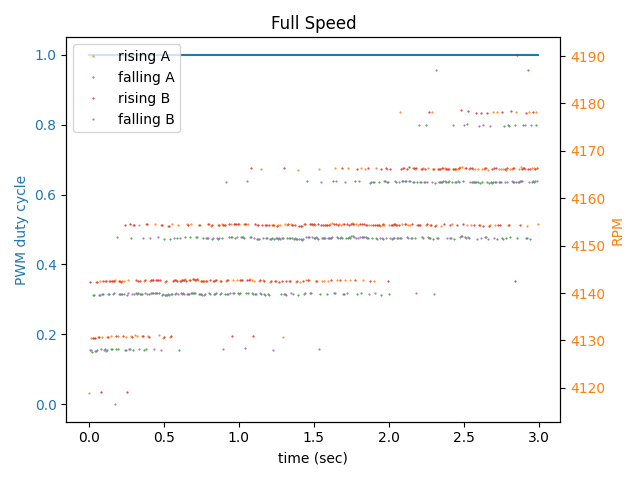

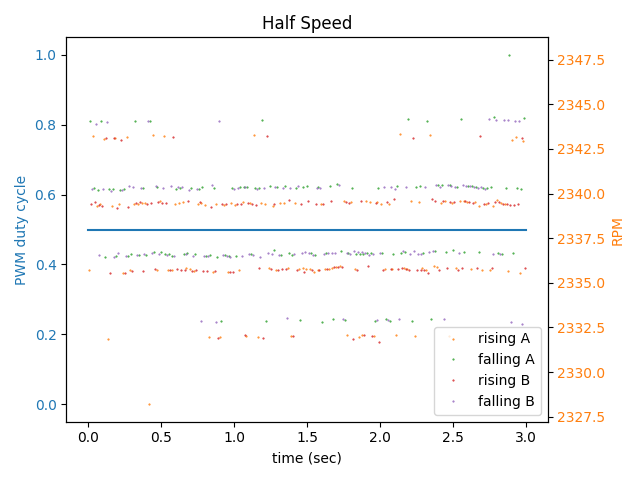

In [18]:
def quad_plot_pwm_tach(title, pwm_pts, tach_pts, fname=None):
    fig, axes = plt.subplots()
    cycler = plt.rcParams['axes.prop_cycle']
    axes.set_title(title)
    axes.set_ylim([-0.05, +1.05])
    pwm_curve, = axes.plot(pwm_pts[:,0], pwm_pts[:,1])
    axes.set_xlabel('time (sec)')
    axes.set_ylabel('PWM duty cycle', color=pwm_curve.get_color())
    axes.tick_params(axis='y', labelcolor=pwm_curve.get_color())

    ax2 = axes.twinx()
    ax2.plot([], []) # skip first color
    from itertools import product
    labels = [f'{d} {n}' for (n, d) in product('AB', ['rising', 'falling'])]
    for i in range(4):
        tach_points, = ax2.plot(tach_pts[i::4,0], tach_pts[i::4,1], '.', markersize=1, label=labels[i])
        if i == 0:
            tach_points.set_markerfacecolor(tach_points.get_color())
            ax2.tick_params(axis='y', labelcolor=tach_points.get_color())
            ax2.set_ylabel('RPM', color=tach_points.get_color())
            # ax2.set_ylim([-200, +4400])
    ax2.legend()
    fig.tight_layout()
    if fname:
        fig.savefig(fname, dpi=600)
    plt.show()


def quad_scenario_plot_pwm_tach(scenario):
    tach_pts = raw_tach_points(scenario)
    fname = scenario.filename
    fname = os.path.splitext(fname)[0]
    fname = os.path.basename(fname)
    fname = 'quad-' + fname + '.png'
    quad_plot_pwm_tach(scenario.title, scenario.pwm_points, tach_pts, fname=fname)

quad_scenario_plot_pwm_tach(full_speed_scenario)
quad_scenario_plot_pwm_tach(half_speed_scenario)

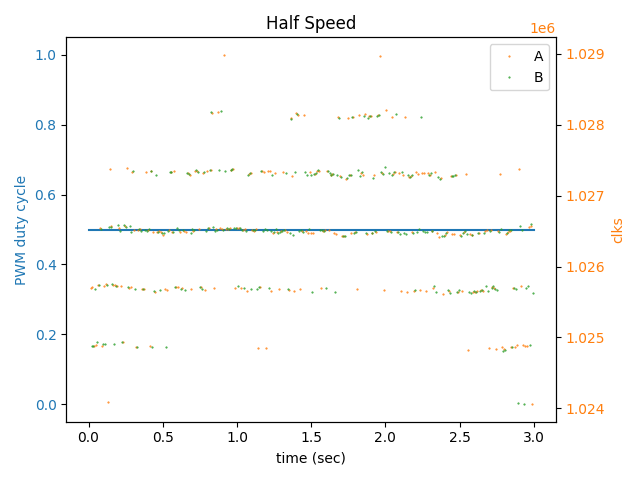

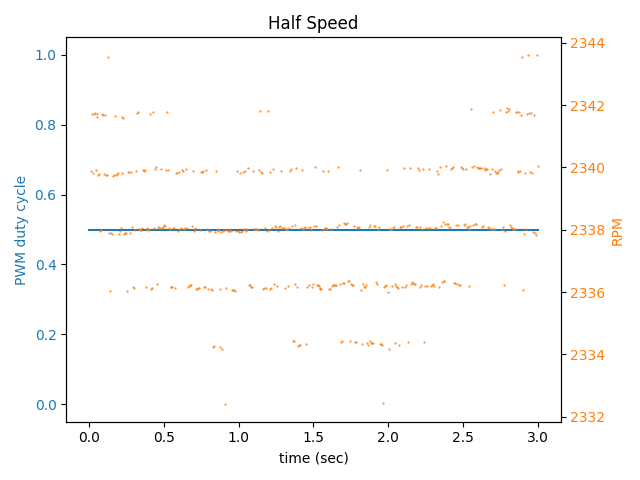

In [19]:
def interleave(a, b):
    # interleave elements of a with b
    # https://stackoverflow.com/q/5347065
    c = np.empty((a.size + b.size, ), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

def dir_tach_clks(scenario):
    """direction fixed tach periods in APB clocks"""
    clk = scenario.tach.clk
    rising = clk[::2]
    falling = clk[1::2]
    rising_x = rising[1:] * CLK_PERIOD_sec
    rising_y = np.diff(rising)
    falling_x = falling[1:] * CLK_PERIOD_sec
    falling_y = np.diff(falling)
    # print(f'{rising_x[:20]=}')
    # print(f'{falling_x[:20]=}')
    x = interleave(rising_x, falling_x)
    y = interleave(rising_y, falling_y)
    return np.vstack([x, y]).T

def dir_tach_rpm(scenario):
    """direction-fixed tach rpms"""
    periods = dir_tach_clks(scenario)
    x = periods[:,0]
    y = periods[:,1]
    # y = CLK_FREQ / np.diff(clk) * 60 / 2 / TACH_PULSES_per_REV
    y = CLK_FREQ / y * 60 / TACH_PULSES_per_REV
    return np.vstack([x, y]).T

def plot_pwm_clks(title, pwm_pts, tach_pts, fname=None):
    fig, axes = plt.subplots()
    axes.set_title(title)
    axes.set_ylim([-0.05, +1.05])
    pwm_curve, = axes.plot(pwm_pts[:,0], pwm_pts[:,1])
    axes.set_xlabel('time (sec)')
    axes.set_ylabel('PWM duty cycle', color=pwm_curve.get_color())
    axes.tick_params(axis='y', labelcolor=pwm_curve.get_color())

    ax2 = axes.twinx()
    ax2.plot([], []) # skip the first color
    tach_points, = ax2.plot(tach_pts[::2,0], tach_pts[::2,1], '.', markersize=1, label='A')
    tach_points.set_markerfacecolor(tach_points.get_color())
    ax2.tick_params(axis='y', labelcolor=tach_points.get_color())
    ax2.set_ylabel('clks', color=tach_points.get_color())
    # ax2.set_ylim([-200, +4400])
    tach_points, = ax2.plot(tach_pts[1::2,0], tach_pts[1::2,1], '.', markersize=1, label='B')
    ax2.legend()
    # print(f'{tach_pts[:20:2,0]=}')
    # print(f'{tach_pts[1:20:2,0]=}')

    fig.tight_layout()
    if fname:
        fig.savefig(fname, dpi=600)
    plt.show()

def period_scenario_plot_pwm_clks(scenario):
    tach_clks = dir_tach_clks(scenario)
    tach_rpm = dir_tach_rpm(scenario)
    fname = scenario.filename
    fname = os.path.splitext(fname)[0]
    fname = os.path.basename(fname)
    clks_fname = 'clks-' + fname + '.png'
    rpm_fname = 'rpm-' + fname + '.png'

    plot_pwm_clks(scenario.title, scenario.pwm_points, tach_clks, clks_fname)
    plot_pwm_tach(scenario.title, scenario.pwm_points, tach_rpm, rpm_fname)

# period_scenario_plot_pwm_clks(full_speed_scenario)
period_scenario_plot_pwm_clks(half_speed_scenario)

In [21]:
 def find_bands(scenario, bands, verbose=False):
    print(f'{scenario.description}')
    clks = dir_tach_clks(scenario)
    y = clks[:,1]
    # print(f'{y.size=}')
    y_width = y.max() - y.min()
    b_width = y_width / (bands - 1)
    if verbose:
        print(f'    band width    = {round(b_width)}')
    band_means = np.empty(bands)
    band_counts = np.empty(bands, dtype=np.int64)
    for i in range(bands):
        center = y.min() + i * b_width
        bottom = center - b_width / 2
        top = center + b_width / 2
        band_samples = y[np.logical_and(bottom <= y, y < top)]
        max_min = band_samples.max() - band_samples.min()
        mean = np.average(band_samples)
        std = np.std(band_samples)
        band_counts[i] = band_samples.size
        band_means[i] = mean
        if verbose:
            print(f'    Band {i}:')
            print(f'        n         = {band_samples.size}')
            print(f'        center    = {center}')
            print(f'        max - min = {max_min:g}')
            print(f'        mean      = {mean:.0f}')
            print(f'        std dev   = {std:g}')

    delta = np.diff(band_means)
    good = np.logical_and(band_counts[:-1] > 5, band_counts[1:] > 5)
    avg_width = np.mean(delta[good])
    avg_period_usec = avg_width * CLK_PERIOD_usec
    avg_freq_hz = CLK_FREQ / avg_width

    # print(f'    {delta=}')
    # print(f'    {good=}')
    print(f'    average width = {avg_width:g} clks')
    print(f'                  = {avg_period_usec:g} \N{MICRO SIGN}sec')
    print(f'                  = {avg_freq_hz:g} Hz')
    print()

find_bands(half_speed_scenario, 7)
find_bands(full_speed_scenario, 10)

Half speed scenario
    average width = 813.561 clks
                  = 10.1695 µsec
                  = 98333.2 Hz

Full speed scenario
    average width = 824.301 clks
                  = 10.3038 µsec
                  = 97051.9 Hz

